**Install necessary Libraries**

In [ ]:
!pip install gymnasium[mujoco]

**Import Necessary Libraries**

In [ ]:
from __future__ import annotations

import sys
import random
import argparse
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

import gymnasium as gym


**Define Policy Network for continuous action space**

In [ ]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Creates a neural network responsible for predicting the mean and
        standard deviation of a normal distribution from which actions are
        subsequently sampled.

        Args:
            obs_space_dims: The dimensions of the observation space
            action_space_dims: The dimensions of the action space
        """
        super().__init__()

        hidden_space1 = 16
        hidden_space2 = 32

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Initialize log_std as a parameter
        self.log_std = nn.Parameter(torch.zeros(action_space_dims))

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Given an observation, this function provides the mean and standard deviation for sampling an action from a normal distribution.

            Arguments:
                x: The observation obtained from the environment

            Returns:
                action_means: The predicted mean of the normal distribution
                action_stddevs: The predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = self.log_std.exp()

        return action_means, action_stddevs

#####**Define Value Network**

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.fc(x)

##### **Define PolicyGradientAgent**

In [ ]:
class PolicyGradientAgent:
    """Unified Policy Gradient algorithm that can work with or without a baseline."""

    def __init__(self, env, obs_space_dims, action_space_dims, lr=1e-5, use_baseline=False):
        """Initializes an agent that learns a policy via REINFORCE or PGB algorithm.

        Args:
            obs_space_dims: Dimension of the observation space.
            action_space_dims: Dimension of the action space.
            lr: Learning rate for policy optimization.
            use_baseline: Whether to use a baseline (value network).
        """
        self.learning_rate = lr
        self.gamma = 0.99
        self.eps = 1e-6
        self.use_baseline = use_baseline
        self.env = env

        self.probs = []
        self.rewards = []
        self.states = [] if use_baseline else None

        self.policy_net = Policy_Network(obs_space_dims, action_space_dims)
        self.policy_optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=self.learning_rate)

        if use_baseline:
            self.value_net = ValueNetwork(obs_space_dims, 16)
            self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=1e-5)

    def sample_action(self, state: np.ndarray) -> np.ndarray:
        state_tensor = torch.tensor(np.array([state]), dtype=torch.float32)
        action_means, action_stddevs = self.policy_net(state_tensor)
        distrib = Normal(action_means[0], action_stddevs[0].clamp(min=self.eps))
        action = distrib.sample()
        prob = distrib.log_prob(action)
        self.probs.append(prob)
        return action.clamp(min=self.env.action_space.low[0], max=self.env.action_space.high[0]).numpy()

    def update(self):
        # Calculate reward-to-go for all time steps
        R = 0
        deltas = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            deltas.insert(0, R)

        # Convert list to tensor
        deltas = torch.tensor(deltas, dtype=torch.float32)

        # Calculate policy loss
        policy_loss = -torch.stack(self.probs).mean() * deltas

        # Update the policy network
        self.policy_optimizer.zero_grad()
        # Sum or average the elements to create a scalar loss
        scalar_policy_loss = policy_loss.sum()  # or policy_loss.mean()

        # Now you can call backward on the scalar loss
        scalar_policy_loss.backward()
        self.policy_optimizer.step()

        # If using baseline, calculate value loss and update value network
        if self.use_baseline:
            states_tensor = torch.tensor(np.array(self.states), dtype=torch.float32)
            values = self.value_net(states_tensor).squeeze()
            advantages = deltas - values

            value_loss = (advantages ** 2).mean()
            self.value_optimizer.zero_grad()
            # # Sum or average the elements to create a scalar loss
            # scalar_value_loss = policy_loss.sum()  # or policy_loss.mean()

            # # Now you can call backward on the scalar loss
            # scalar_value_loss.backward()
            value_loss.backward()
            self.value_optimizer.step()

        # Reset episode data
        self.probs = []
        self.rewards = []
        if self.use_baseline:
            self.states = []


##### **Training Loop-Function-Vanilla Policy Gradient**

In [ ]:
# Define a function to run the Vanilla Policy Gradient (REINFORCE) algorithm
def run_vanilla_pg(env, total_num_episodes, seeds, obs_space_dims, action_space_dims):
    rewards_over_seeds = []

    for seed in seeds:
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        agent = PolicyGradientAgent(env, obs_space_dims, action_space_dims, use_baseline=False)  # Initialize the REINFORCE agent
        reward_over_episodes = []

        for episode in range(total_num_episodes):
            obs, info = env.reset()
            done = False
            while not done:
                action = agent.sample_action(obs)
                obs, reward, terminated, truncated, info = env.step(action)
                agent.rewards.append(reward)
                done = terminated or truncated

            reward_over_episodes.append(sum(agent.rewards))
            agent.update()

            if episode % 1000 == 0:
                avg_reward = np.mean(reward_over_episodes[-100:])  # Calculate average of last 100 episodes
                print("Episode: ", episode, "Average Reward: ", avg_reward)

        rewards_over_seeds.append(reward_over_episodes)

    return rewards_over_seeds

##### **Training Loop-Function-Policy Gradient with Baseline**

In [ ]:
# Define a function to run the Policy Gradient with Baseline algorithm
def run_pgb(env, total_num_episodes, seeds, obs_space_dims, action_space_dims, learning_rate):
    rewards_over_seeds = []

    for seed in seeds:
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        agent = PolicyGradientAgent(env, obs_space_dims, action_space_dims,
                                    lr=learning_rate, use_baseline=True)  # Initialize the PGB agent
        reward_over_episodes = []

        for episode in range(total_num_episodes):
            obs, info = env.reset()
            done = False
            while not done:
                action = agent.sample_action(obs)
                agent.states.append(obs)
                obs, reward, terminated, truncated, info = env.step(action)
                agent.rewards.append(reward)
                done = terminated or truncated

            reward_over_episodes.append(sum(agent.rewards))
            agent.update()

            if episode % 1000 == 0:
                avg_reward = np.mean(reward_over_episodes[-100:])  # Calculate average of last 100 episodes
                print("Episode: ", episode, "Average Reward: ", avg_reward)

        rewards_over_seeds.append(reward_over_episodes)

    return rewards_over_seeds

**Plotting**

##### rolling average function

In [ ]:
def rolling_average(data, window_size=10):
    """Compute rolling average for smoother plots."""
    return pd.Series(data).rolling(window=window_size).mean()

In [ ]:
def plot_learning_curve(smoothed_rewards, label, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    plt.plot(smoothed_rewards, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_combined_learning_curve(smoothed_rewards, label, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    plt.plot(smoothed_rewards, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

#**Main function**

In [ ]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--algo', type=str, default='pg', choices=['pg', 'pgb'],
                        help='Algorithm to run: "pg" for vanilla policy gradient, "pgb" for policy gradient with baseline')
    args = parser.parse_args()

    env = gym.make("Ant-v4")
    total_num_episodes = 5000
    seeds = [8]  # List of seeds you want to use
    obs_space_dims = env.observation_space.shape[0]
    action_space_dims = env.action_space.shape[0]

    if args.algo == 'pg':
        # Run Vanilla Policy Gradient
        rewards_vpg = run_vanilla_pg(env, total_num_episodes, seeds, obs_space_dims, action_space_dims)

        # Flatten the list to have a single list of rewards over all episodes
        flattened_rewards = [reward for seed_rewards in rewards_vpg for reward in seed_rewards]

        # Compute rolling average
        smoothed_rewards = rolling_average(flattened_rewards, window_size=50)

        plot_learning_curve( smoothed_rewards, 'Vanilla Policy Gradient',
                            'Learning Curve for Vanilla Policy Gradient Algorithm on Ant-v4',
                            'Episodes',
                            'Undiscounted Return'
                            )
        ### save variable smoothed_rewards

    elif args.algo == 'pgb':
        # Run Policy Gradient with Baseline
        rewards_pgb = run_pgb(env, total_num_episodes, seeds, obs_space_dims,
                              action_space_dims, learning_rate= 1e-5)

        # Flatten the list to have a single list of rewards over all episodes
        flattened_rewards = [reward for seed_rewards in rewards_pgb for reward in seed_rewards]

        # Compute rolling average
        smoothed_rewards = rolling_average(flattened_rewards, window_size=50)

        plot_learning_curve( smoothed_rewards, 'Policy Gradient with Baseline',
                            'Learning Curve for Policy Gradient with Baseline Algorithm on Ant-v4',
                            'Episodes',
                            'Undiscounted Return'
                            )

        # Question 3
        learning_rates = [1e-4, 1e-5, 1e-6]
        results = {}

        for lr in learning_rates:
            print(f"Running experiment with learning rate: {lr}")
            rewards_pgb = run_pgb(env, total_num_episodes, seeds, obs_space_dims,
                              action_space_dims, learning_rate= lr)
            flattened_reward = [reward for seed_rewards in rewards_pgb for reward in seed_rewards]
            results[f"lr={lr}"] = flattened_reward

        plt.figure(figsize=(12, 8))

        for lr, rewards in results.items():
            smoothed_rewards = rolling_average(rewards, window_size=50)
            plt.plot(smoothed_rewards, label=lr)

        plt.title('Learning Curves for Different Learning Rates in PGB Algorithm')
        plt.xlabel('Episodes')
        plt.ylabel('Undiscounted Return')
        plt.legend()
        plt.grid(True)
        plt.show()


##### **PG algorithm output**

Episode:  0 Average Reward:  -38.3722569940707
Episode:  1000 Average Reward:  -142.5412074282239
Episode:  2000 Average Reward:  -133.20385312322185
Episode:  3000 Average Reward:  -101.3894163135508
Episode:  4000 Average Reward:  -153.6745736014923


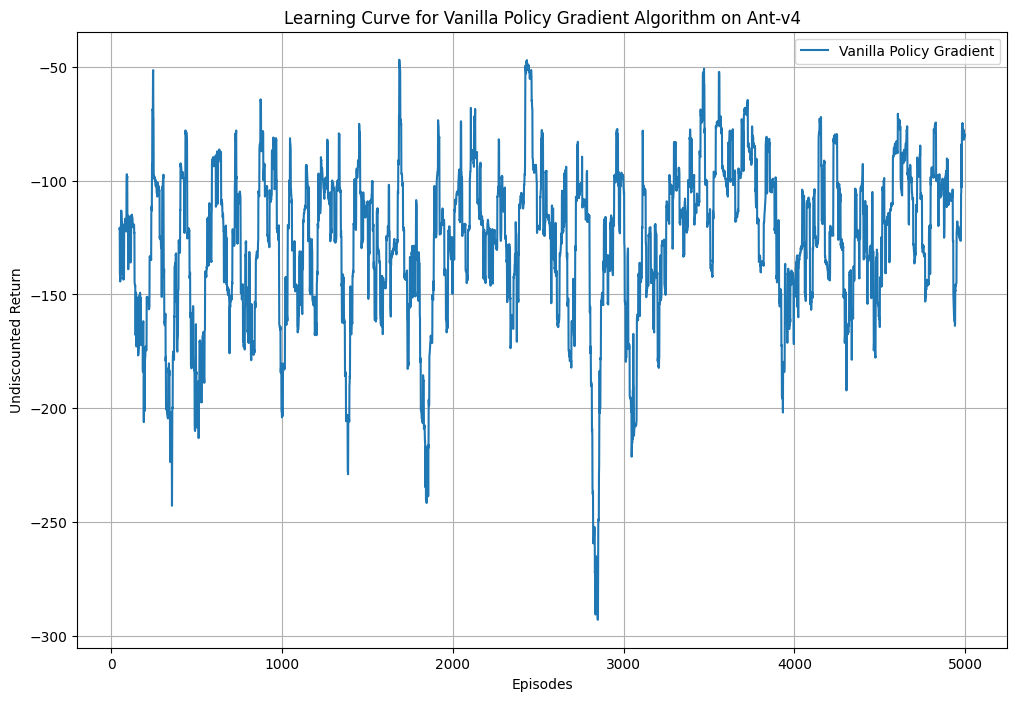

In [ ]:
# Simulate command-line argument: replace 'pg' with 'pgb' to run policy gradient with baseline
sys.argv = ['hw2_F.py', '--algo', 'pg']

# Then call the main function
if __name__ == '__main__':
    main()

##### **PGB algorithm output**

Episode:  0 Average Reward:  -59.20542941625349
Episode:  1000 Average Reward:  -114.72267109077255
Episode:  2000 Average Reward:  -92.31426428371581
Episode:  3000 Average Reward:  -152.1896180178551
Episode:  4000 Average Reward:  -103.55475125602347


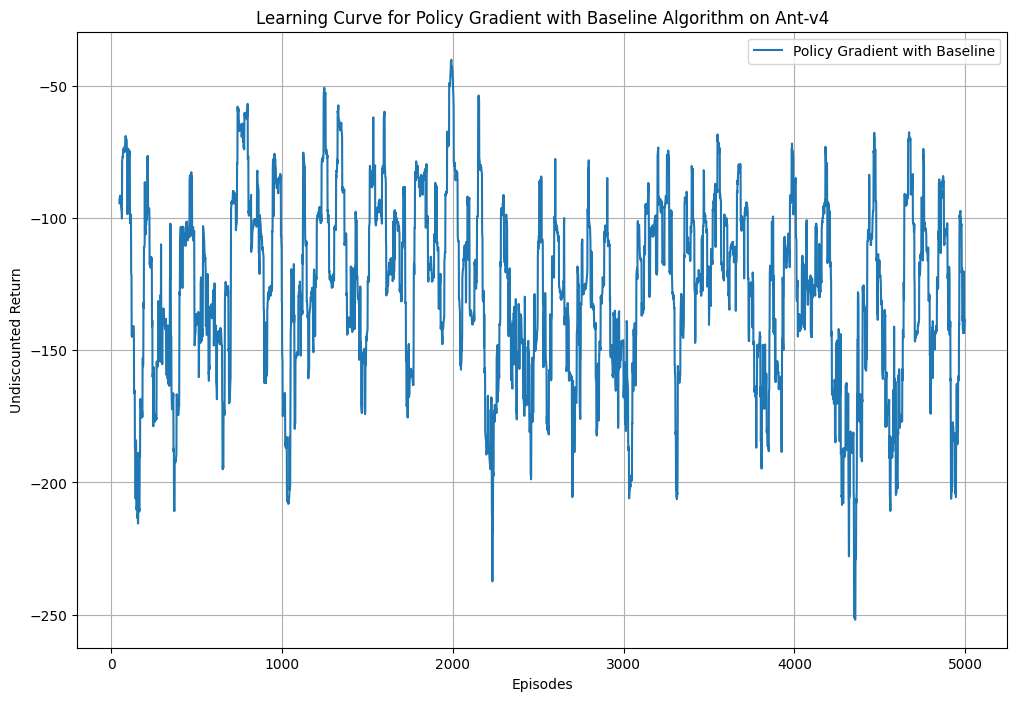

Running experiment with learning rate: 0.0001
Episode:  0 Average Reward:  -74.51237787356047
Episode:  1000 Average Reward:  -116.63374839610125
Episode:  2000 Average Reward:  -141.0960428273539
Episode:  3000 Average Reward:  -100.1127510928168
Episode:  4000 Average Reward:  -167.94084120539
Running experiment with learning rate: 1e-05
Episode:  0 Average Reward:  -44.48651343751414
Episode:  1000 Average Reward:  -135.58542316701477
Episode:  2000 Average Reward:  -93.82546841978532
Episode:  3000 Average Reward:  -136.1494972191289
Episode:  4000 Average Reward:  -143.8363538322467
Running experiment with learning rate: 1e-06
Episode:  0 Average Reward:  -60.23545479633949
Episode:  1000 Average Reward:  -122.50935612246671
Episode:  2000 Average Reward:  -118.95391982287322
Episode:  3000 Average Reward:  -127.64069280982977
Episode:  4000 Average Reward:  -157.69421967281787


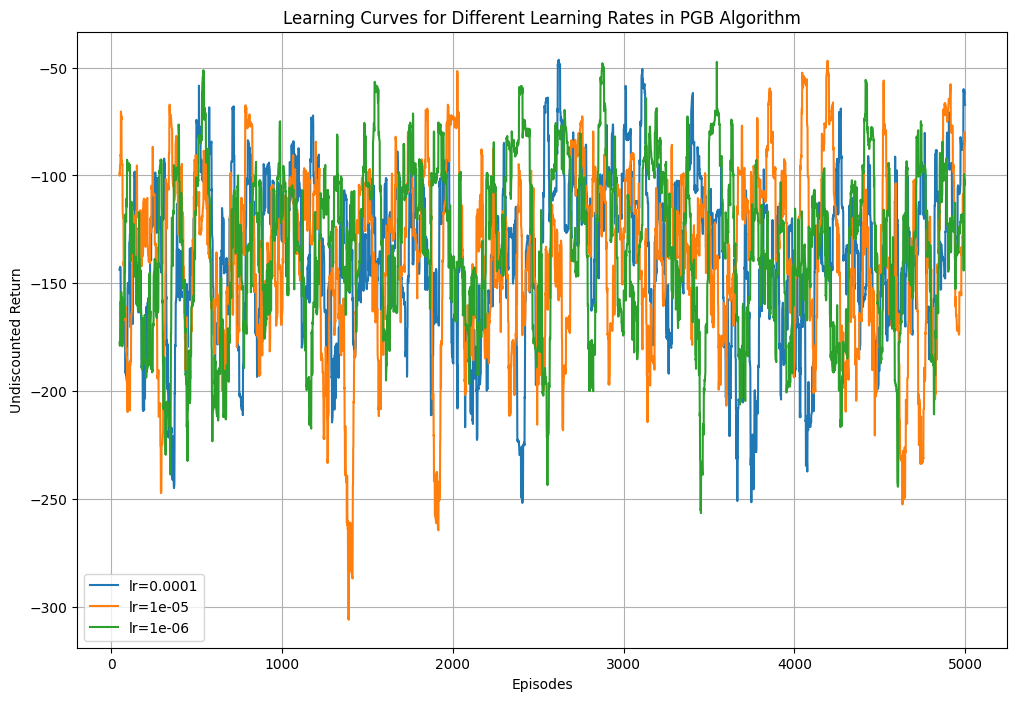

In [ ]:
# Simulate command-line argument: replace 'pg' with 'pgb' to run policy gradient with baseline
sys.argv = ['hw2_F.py', '--algo', 'pgb']

# Then call the main function
if __name__ == '__main__':
    main()

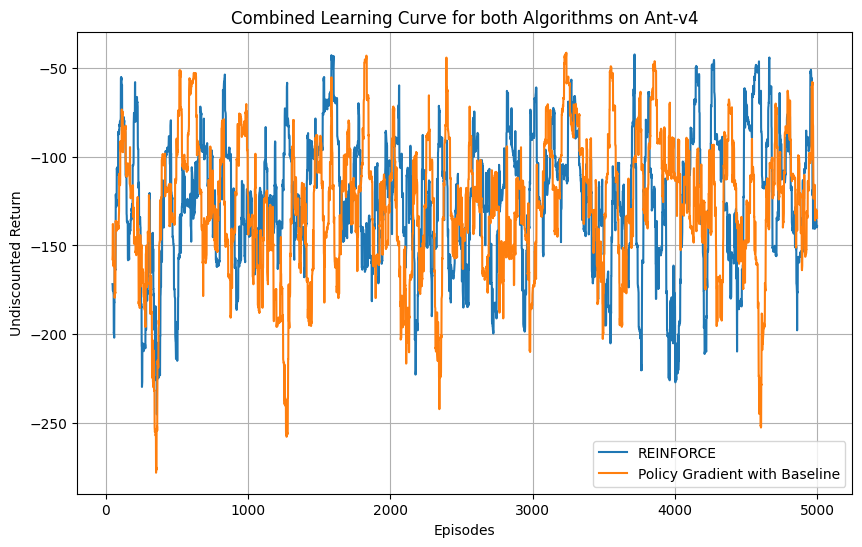